<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/research/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Dependencies

In [1]:
!python3 -m pip install --upgrade pip
!python3 -m pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
			  torch \
              torchvision \
			  pycocotools \
			  pandas \
			  seaborn \
              torchviz -U && echo "Dependencies installation complete."

Dependencies installation complete.


## WandB login

In [1]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wych (almtech). Use `wandb login --relogin` to force relogin


True

# Definitions

## Dataset Handler Definition

In [2]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 8

In [3]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor):
    return _tensor_pil_transform(tensor)

In [23]:
import torch
import numpy as np 
import os

from typing import List, Tuple

from torch.utils.data import Dataset

from PIL import Image

class COCOInstanceDataset(Dataset):
    def __init__(self, dataset_dir: str = "dataset/train/", target_size: Tuple[int, int] = (512, 512)):
        self.dataset_dir = dataset_dir
        self.data = __class__.get_mask_image_pairs(dataset_dir)
        self.target_size = target_size

    @staticmethod
    def get_mask_image_pairs(directory: str) -> List[Tuple[str, str]]:
        mask_image_pairs = [
            (
                os.path.join(directory, filename),
                os.path.join(directory, f"{os.path.splitext(filename)[0]}_mask.png")
            )
            for filename in os.listdir(directory)
            if filename.endswith(".jpg") and os.path.isfile(os.path.join(directory, f"{os.path.splitext(filename)[0]}_mask.png"))
        ]
        return mask_image_pairs

    def resize_image_mask(self, img, mask):
        img = np.array(img)
        mask = np.array(mask)

        if img.shape[0] < self.target_size[0]:
            pad = self.target_size[0] - img.shape[0]
            img = np.pad(img, ((pad, 0), (0, 0), (0, 0)), mode='constant', constant_values=0)
            mask = np.pad(mask, ((pad, 0), (0, 0)), mode='constant', constant_values=0)

        if img.shape[1] < self.target_size[1]:
            pad = self.target_size[1] - img.shape[1]
            img = np.pad(img, ((0, 0), (pad, 0), (0, 0)), mode='constant', constant_values=0)
            mask = np.pad(mask, ((0, 0), (pad, 0)), mode='constant', constant_values=0)

        return Image.fromarray(img), Image.fromarray(mask)
        
    def __getitem__(self, idx: int):
        img_file, mask_file = self.data[idx]
        img = Image.open(img_file).convert("RGB")
        mask = Image.open(mask_file) 

        # Pad w/h to fit 512x512
        img, mask = self.resize_image_mask(img, mask)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        num_objs = len(obj_ids)

        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])

        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        return T.ToTensor()(img), target
    
    def __len__(self):
        return len(self.data)

In [27]:
from torch.utils.data import DataLoader

dataset = COCOInstanceDataset(dataset_dir="dataset/full/")
dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

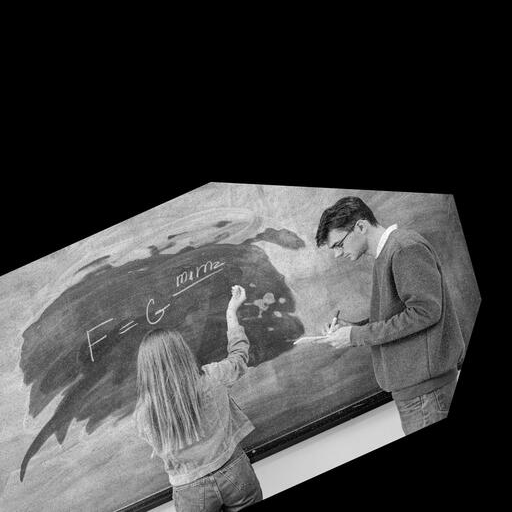

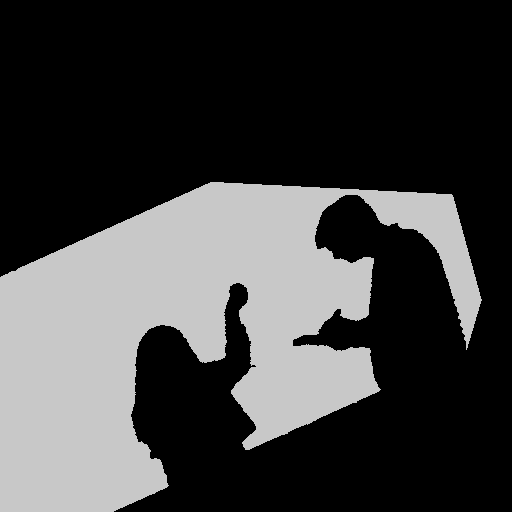

In [40]:
for batch in dataloader:
    img, target = batch
    mask = target["masks"]

    display(tensor_to_pil(img.squeeze(0)))
    display(tensor_to_pil(mask.squeeze(0) * 200))

    break

## FeynMAN Model Definition

In [41]:
import torch.nn as nn

class FeynMAN(nn.Module):
    def __init__(self, num_classes: int = 3):
        super(__class__, self).__init__()

        # Backbone (You can replace this with your custom backbone)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Region Proposal Network (RPN)
        self.rpn_conv = nn.Conv2d(64, 512, kernel_size=3, stride=1, padding=1)
        self.rpn_cls = nn.Conv2d(512, 2, kernel_size=1, stride=1)
        self.rpn_reg = nn.Conv2d(512, 4, kernel_size=1, stride=1)

        # RoI Heads
        self.roi_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc1 = nn.Linear(7*7*512, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes + 1)
        self.bbox_pred = nn.Linear(1024, (num_classes + 1) * 4)

        # Mask Heads
        self.mask_conv1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.mask_conv2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.mask_deconv = nn.ConvTranspose2d(512, num_classes, kernel_size=2, stride=2)

    def forward(self, x):
        # Backbone
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # RPN
        rpn_feature = self.rpn_conv(x)
        rpn_cls = self.rpn_cls(rpn_feature)
        rpn_reg = self.rpn_reg(rpn_feature)

        # RoI Heads
        x = self.roi_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_score = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)

        # Mask Heads
        mask_feature = self.mask_conv1(x)
        mask_feature = self.mask_conv2(mask_feature)
        mask = self.mask_deconv(mask_feature)

        return rpn_cls, rpn_reg, cls_score, bbox_pred, mask

# Training

In [43]:
!nvidia-smi && echo "YES YOU CAN TRAIN WITH CUDA!"

Sat Sep 23 14:42:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...    Off | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P5              21W / 140W |    532MiB /  6144MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [44]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model: nn.Module,
    dataloader: DataLoader,
    epochs: int = EPOCHS,
    learning_rate: float = LEARNING_RATE,
    device: torch.device = torch.device("cpu"),
    batch_size: int = BATCH_SIZE,
):
    # Watch the model for cool weights & biases
    wandb.watch(model)

    # criterion = nn.CrossEntropyLoss() # nn.BCELoss() #### TODO: change?
    # optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    params = model.parameters()
    optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=learning_rate/10)

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        train_epoch_loss = 0
        val_epoch_loss = 0
        model.train()

        for batch_idx, dt in enumerate(dataloader):
            imgs = [dt[0][0].to(device) , dt[1][0].to(device)]

            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]

            loss = model(imgs, targets)
            losses = sum([l for l in loss.values()])

            train_epoch_loss += losses.cpu().detach().numpy()

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            print(
                f" # Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
            )
            
            # Log to WandB
            wandb.log({"loss": loss})
            wandb.log({"train_epoch_loss": train_epoch_loss})
            wandb.log({"val_epoch_loss": val_epoch_loss})

    # for epoch in range(epochs):
    #     model.train()
    #     running_loss = 0.0

    #     for batch_idx, (images, labels) in enumerate(dataloader):
    #         # Convert to the GPU or other devicetype
    #         images, labels = images.to(device).float(), labels.to(device)

    #         optimizer.zero_grad()

    #         # Forward pass
    #         rpn_cls, rpn_reg, cls_score, bbox_pred, mask = model(images)

    #         # Define your loss calculation based on your problem
    #         # For example, if you're doing object detection, you'd need to define the losses for rpn_cls, rpn_reg, cls_score, and bbox_pred
    #         # Similarly, for a segmentation task, you'd need to define the loss for the mask

    #         loss = your_loss_function(rpn_cls, rpn_reg, cls_score, bbox_pred, mask, labels)
    #         wandb.log({"Loss": loss})

    #         # Backward and optimize
    #         loss.backward()
    #         optimizer.step()

    #         running_loss += loss.item()

    #         print(
    #             f" # Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
    #         )

    #         del images, labels

    #     # Log the running loss
    #     wandb.log({"Running loss": running_loss})


    # print("BEGIN TRAINING!")
    # for epoch in range(epochs):
    #     model.train()
    #     running_loss = 0.0
    #     print(epoch)

    #     for batch_idx, (images, masks) in enumerate(dataloader):
    #         images, masks = images.to(device).float(), masks.to(device).float()
    #         print("Running batch: ", batch_idx)
            
    #         # Forward pass
    #         print(" - Forward pass")
    #         outputs = model(images)
    #         # preds = torch.argmax(outputs, dim=1).float()
    #         print(" - Loss calc")
    #         loss = criterion(outputs, masks)

    #         # Backpropagation and optimization
    #         print(" - Zero grad")
    #         optimizer.zero_grad()
    #         print(" - Backward prop")
    #         loss.backward()
    #         print(" - Optim step")
    #         optimizer.step()

    #         running_loss += loss.item()
    #         wandb.log({"Loss": loss})


    #         del images, masks

    #     wandb.log({"Running loss": running_loss})

    print("END TRAINING!")
    wandb.finish()

### Model creation

In [45]:
model = FeynMAN()
device_type = "cuda" if torch.cuda.is_available() else "cpu"
#device_type = "cpu"
device = torch.device(device_type)

# start a new wandb run to track this script
wandb.init(
	# set the wandb project where this run will be logged
	project="feynman_0",

	# track hyperparameters and run metadata
	config={
	"learning_rate": LEARNING_RATE,
	"epochs": EPOCHS,
	"batch_size": BATCH_SIZE,
	"architecture": "FeynMAN",
	"dataset": "feynman_v5i",
	}
)

# Put the model on the GPU
model = model.to(device)

### Start training loop

#### Train the model

In [46]:
# Fix for some CUDA bullshit

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [47]:
print(f"Doing training on device type '{device_type}'!")
torch.cuda.empty_cache()
train_model(model, dataloader=dataloader, device=device, learning_rate=LEARNING_RATE, epochs=EPOCHS)

Doing training on device type 'cuda'!


RuntimeError: stack expects each tensor to be equal size, but got [1, 4] at entry 0 and [2, 4] at entry 2